In [78]:
import zipfile
import os
import random
from PIL import Image, ImageOps, UnidentifiedImageError
import io
import zipfile
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization


In [78]:
# Preprocessing parameters
desired_size = (64, 64)  # Example size, similar to MNIST dataset

# Function to preprocess images: resize and convert to grayscale
def preprocess_image(image):
    image = ImageOps.grayscale(image)  # Convert to grayscale
    image = image.resize(desired_size, Image.Resampling.LANCZOS)  # Resize image using LANCZOS
    return np.array(image)  # Convert to numpy array

# Function to extract the digit label from the zip file name
def extract_digit_from_filename(filename):
    # Assuming the format "Digit-OtherInfo.zip"
    return filename.split('-')[0]

# Function to extract and preprocess images from a zip file
def extract_and_preprocess_images(zip_file_path):
    label = extract_digit_from_filename(os.path.basename(zip_file_path))
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        images_data = {}
        for name in zip_ref.namelist():
            if name.endswith(('.png', '.jpg', '.jpeg')):
                try:
                    # Read image as PIL image
                    image_data = zip_ref.read(name)
                    image = Image.open(io.BytesIO(image_data))
                    # Preprocess image
                    preprocessed_image = preprocess_image(image)
                    # Store image data with label
                    images_data[name] = {'image': preprocessed_image, 'label': label}
                except (OSError, UnidentifiedImageError) as e:
                    print(f"Cannot identify or read image file {name} in {zip_file_path}: {e}")
        return images_data

# First, let's define the directory where the zip files are located
zip_files_dir = r'C:\Users\PC\Downloads\Arabic digits Graduation project\data'
zip_files = [file for file in os.listdir(zip_files_dir) if file.endswith('.zip')]

# Extract, preprocess, and label images from all zip files
all_images_data = []
for zip_file in zip_files:
    print(f"Processing {zip_file}...")
    images_data = extract_and_preprocess_images(os.path.join(zip_files_dir, zip_file))
    all_images_data.extend(list(images_data.values()))
    print(f"Processed {len(images_data)} images from {zip_file}.")





Processing Eight-20240414T070320Z-001.zip...
Processed 251 images from Eight-20240414T070320Z-001.zip.
Processing Five-20240414T070208Z-001.zip...
Processed 256 images from Five-20240414T070208Z-001.zip.
Processing Four-20240414T070029Z-001.zip...
Processed 264 images from Four-20240414T070029Z-001.zip.
Processing Nine-20240413T170740Z-001.zip...
Processed 258 images from Nine-20240413T170740Z-001.zip.
Processing One-20240413T170739Z-001.zip...
Cannot identify or read image file One/Yomna_Yasser_female_21.png in C:\Users\PC\Downloads\Arabic digits Graduation project\data\One-20240413T170739Z-001.zip: cannot identify image file <_io.BytesIO object at 0x0000022DE7DBB330>
Processed 260 images from One-20240413T170739Z-001.zip.
Processing Seven-20240413T170601Z-001.zip...
Processed 264 images from Seven-20240413T170601Z-001.zip.
Processing Six-20240413T170559Z-001.zip...
Processed 254 images from Six-20240413T170559Z-001.zip.
Processing Three-20240413T170557Z-001.zip...
Processed 264 image

In [79]:
if all_images_data:
    first_image_data = all_images_data[1500]
    img = Image.fromarray(first_image_data['image'])
    img.show()
    print(f"First image label: {first_image_data['label']}")

First image label: Seven


Split the dataset

In [80]:

# Mapping from string labels to integers (you should complete this mapping)
label_mapping = {
    'Zero': 0,
    'One': 1,
    'Two': 2,
    'Three': 3,
    'Four': 4,
    'Five': 5,
    'Six': 6,
    'Seven': 7,
    'Eight': 8,
    'Nine': 9
}

def preprocess_dataset(all_images_data):
    # Separate images and labels
    images = np.array([entry['image'] for entry in all_images_data])
    labels = np.array([label_mapping[entry['label']] for entry in all_images_data])
    
    # Normalize the images
    images = images.astype(np.float32) / 255.0
    
    # Convert labels to one-hot encoding
    labels = to_categorical(labels, num_classes=10)  # Assuming 10 classes for Arabic numerals
    
    # Reshape the images to add the channel dimension (1 channel for grayscale)
    images = images.reshape(-1, 64, 64, 1)
    
    return images, labels


def split_dataset(images, labels, train_frac=0.7, valid_frac=0.15):
    # Calculate sizes for each set
    total_size = len(images)
    train_size = int(train_frac * total_size)
    valid_size = int(valid_frac * total_size)
    test_size = total_size - train_size - valid_size

    # Shuffle the data
    indices = np.arange(total_size)
    np.random.shuffle(indices)
    images, labels = images[indices], labels[indices]

    # Split the data
    train_images, train_labels = images[:train_size], labels[:train_size]
    valid_images, valid_labels = images[train_size:train_size+valid_size], labels[train_size:train_size+valid_size]
    test_images, test_labels = images[train_size+valid_size:], labels[train_size+valid_size:]

    return (train_images, train_labels), (valid_images, valid_labels), (test_images, test_labels)

# Preprocess the entire dataset
images, labels = preprocess_dataset(all_images_data)

# Split the dataset
(train_images, train_labels), (valid_images, valid_labels), (test_images, test_labels) = split_dataset(images, labels)

# Output the sizes of the splits
print(f"Training set size: {len(train_images)}")
print(f"Validation set size: {len(valid_images)}")
print(f"Testing set size: {len(test_images)}")


Training set size: 1815
Validation set size: 388
Testing set size: 390


In [12]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                     activation='relu', input_shape=(64, 64, 1)))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                     activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))  # Assuming 10 classes for digits 0-9
    return model

# Compile the model
model = build_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,279,018 (16.32 MB)

 Trainable params: 4,279,018 (16.32 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Configure early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(
    monitor='val_loss',      # Monitor the validation loss
    patience=5,              # Number of epochs with no improvement after which training will be stopped
    verbose=1,               # To output the progress
    restore_best_weights=True # Restores model weights from the epoch with the best value of the monitored quantity
)

# Fit the model
history = model.fit(
    train_images, train_labels,
    epochs=50,                    # Maximum number of epochs to train for
    batch_size=32,                # The size of the batches to use during training
    validation_data=(valid_images, valid_labels), # Validation data to monitor
    callbacks=[early_stopping_callback]           # Early stopping callback
)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.1064 - loss: 2.3443 - val_accuracy: 0.0928 - val_loss: 2.3034
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.1124 - loss: 2.3019 - val_accuracy: 0.1186 - val_loss: 2.3034
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.1165 - loss: 2.2897 - val_accuracy: 0.2062 - val_loss: 2.2156
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.2073 - loss: 2.1705 - val_accuracy: 0.3660 - val_loss: 1.9553
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.3321 - loss: 1.9451 - val_accuracy: 0.4536 - val_loss: 1.7198
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.4274 - loss: 1.6297 - val_accuracy: 0.5438 - val_loss: 1.4793
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.5384 - loss: 1.3882 - val_accuracy: 0.6237 - val_loss: 1.2548
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.6101 - loss: 1.1811 - val_accuracy: 0.6263 - v

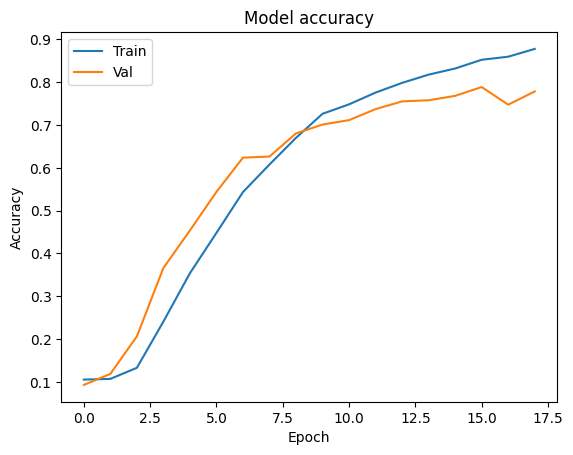

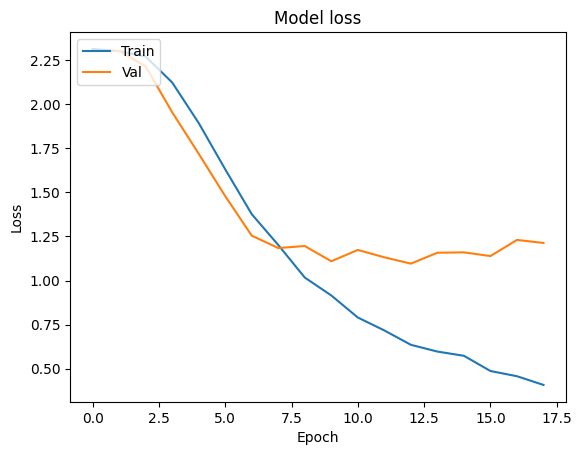

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [15]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

13/13 - 0s - 20ms/step - accuracy: 0.7000 - loss: 1.1977
Test Loss: 1.1976659297943115
Test Accuracy: 0.699999988079071


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


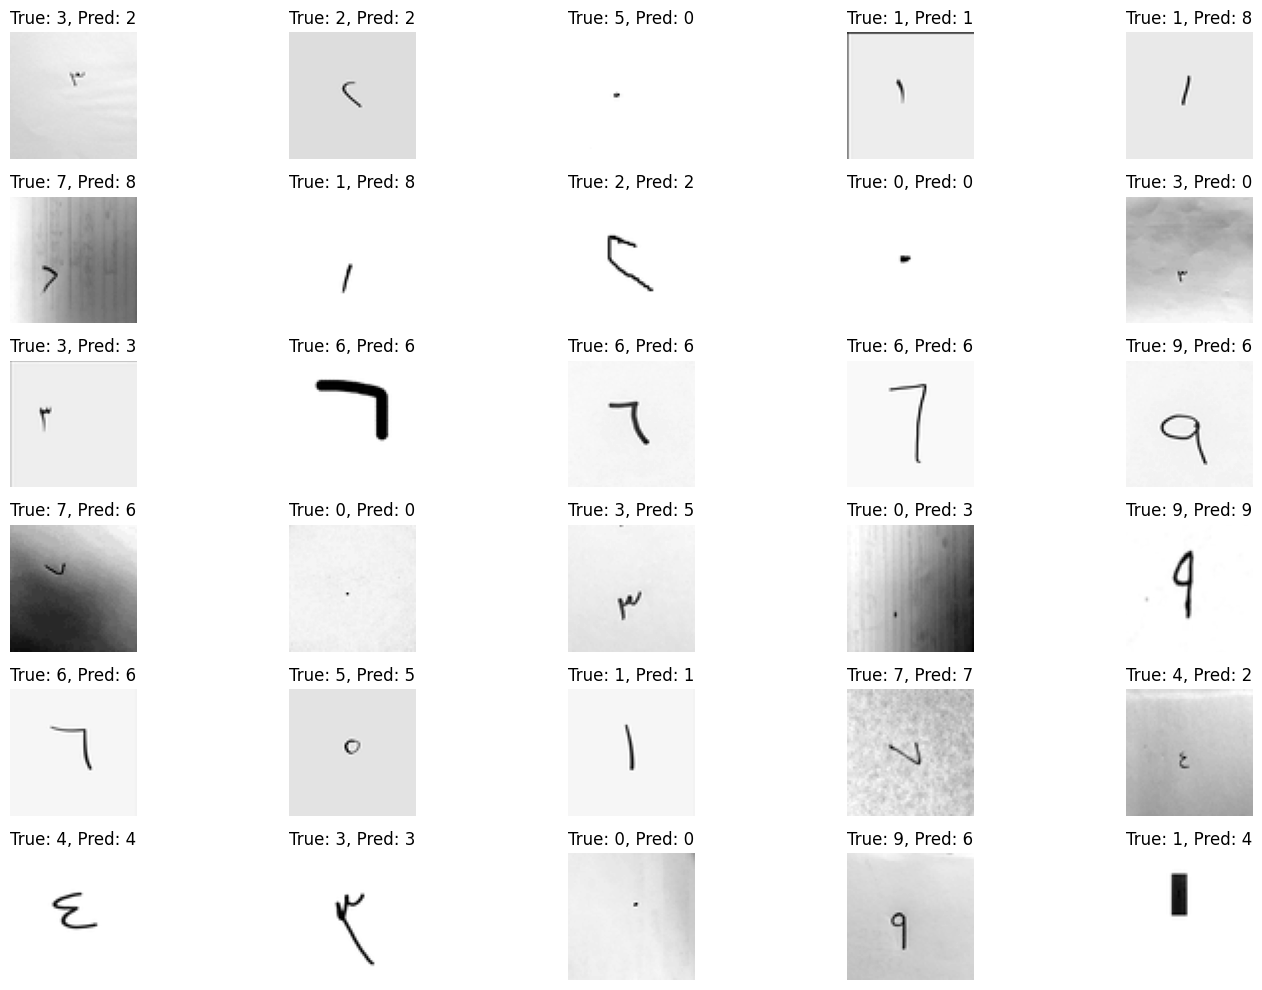

In [18]:
# Making predictions on the test set
predictions = model.predict(test_images)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Show some of the predictions

def plot_images(images, true_labels, predicted_labels):
    plt.figure(figsize=(15, 10))
    for i in range(30):  # Let's visualize the first 15 images
        plt.subplot(6, 5, i + 1)
        plt.imshow(images[i].reshape(64, 64), cmap='gray')
        plt.title(f"True: {true_labels[i]}, Pred: {predicted_labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function
plot_images(test_images, true_classes, predicted_classes)


In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_model2():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                     activation='relu', input_shape=(64, 64, 1)))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                     activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))  # Assuming 10 classes for digits 0-9
    return model

# Compile the model
model3 = build_model2()
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model3.summary()

c:\Users\PC\Downloads\Arabic digits Graduation project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 64, 64, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 64, 64, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,279,018 (16.32 MB)

 Trainable params: 4,279,018 (16.32 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Configure early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(
    monitor='val_loss',      # Monitor the validation loss
    patience=10,              # Number of epochs with no improvement after which training will be stopped
    verbose=1,               # To output the progress
    restore_best_weights=True # Restores model weights from the epoch with the best value of the monitored quantity
)


checkpoint_path = "model3_weights_best.weights.h5"  # Changed the extension as per the error message
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',  # or 'val_loss' if you prefer to monitor the loss
    mode='max',  # 'min' if you monitor the loss
    save_best_only=True,
    verbose=1,
)
# Fit the model
history2 = model3.fit(
    train_images, train_labels,
    epochs=50,                    # Maximum number of epochs to train for
    batch_size=32,                # The size of the batches to use during training
    validation_data=(valid_images, valid_labels), # Validation data to monitor
    callbacks=[model_checkpoint_callback , early_stopping_callback]           # Early stopping callback
)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.0869 - loss: 2.3648
Epoch 1: val_accuracy improved from -inf to 0.09278, saving model to model3_weights_best.weights.h5
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.0870 - loss: 2.3641 - val_accuracy: 0.0928 - val_loss: 2.3031
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.1275 - loss: 2.3003
Epoch 2: val_accuracy improved from 0.09278 to 0.13918, saving model to model3_weights_best.weights.h5
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.1276 - loss: 2.3003 - val_accuracy: 0.1392 - val_loss: 2.2764
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.1975 - loss: 2.2047
Epoch 3: val_accuracy improved from 0.13918 to 0.36082, saving model to model3_weights_best.weights.h5
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.1983 - loss: 2.2036 - val_accuracy: 0.3608 - val_loss: 2.0095
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.3257 - loss: 1.9221
Epoch 

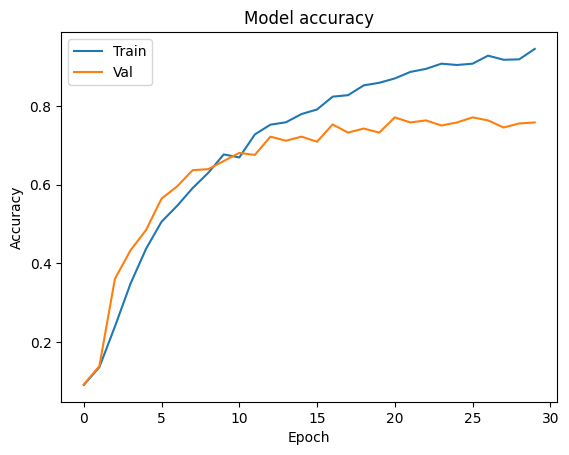

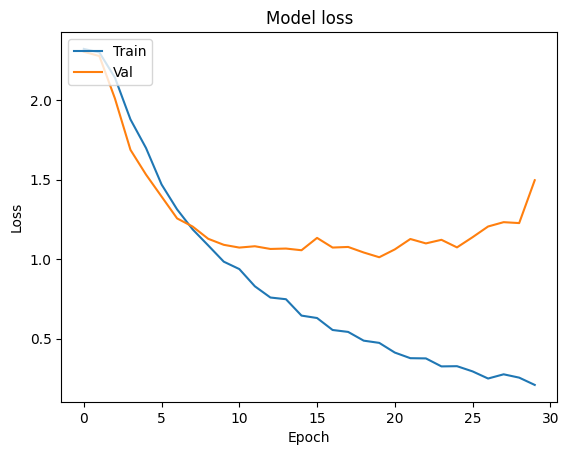

In [58]:
# Plot training & validation accuracy values
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [60]:
model3.load_weights("model3_weights_best.weights.h5")

test_loss, test_accuracy = model3.evaluate(test_images, test_labels, verbose=2)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


13/13 - 0s - 19ms/step - accuracy: 0.7128 - loss: 1.2617
Test Loss: 1.2616673707962036
Test Accuracy: 0.7128205299377441


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


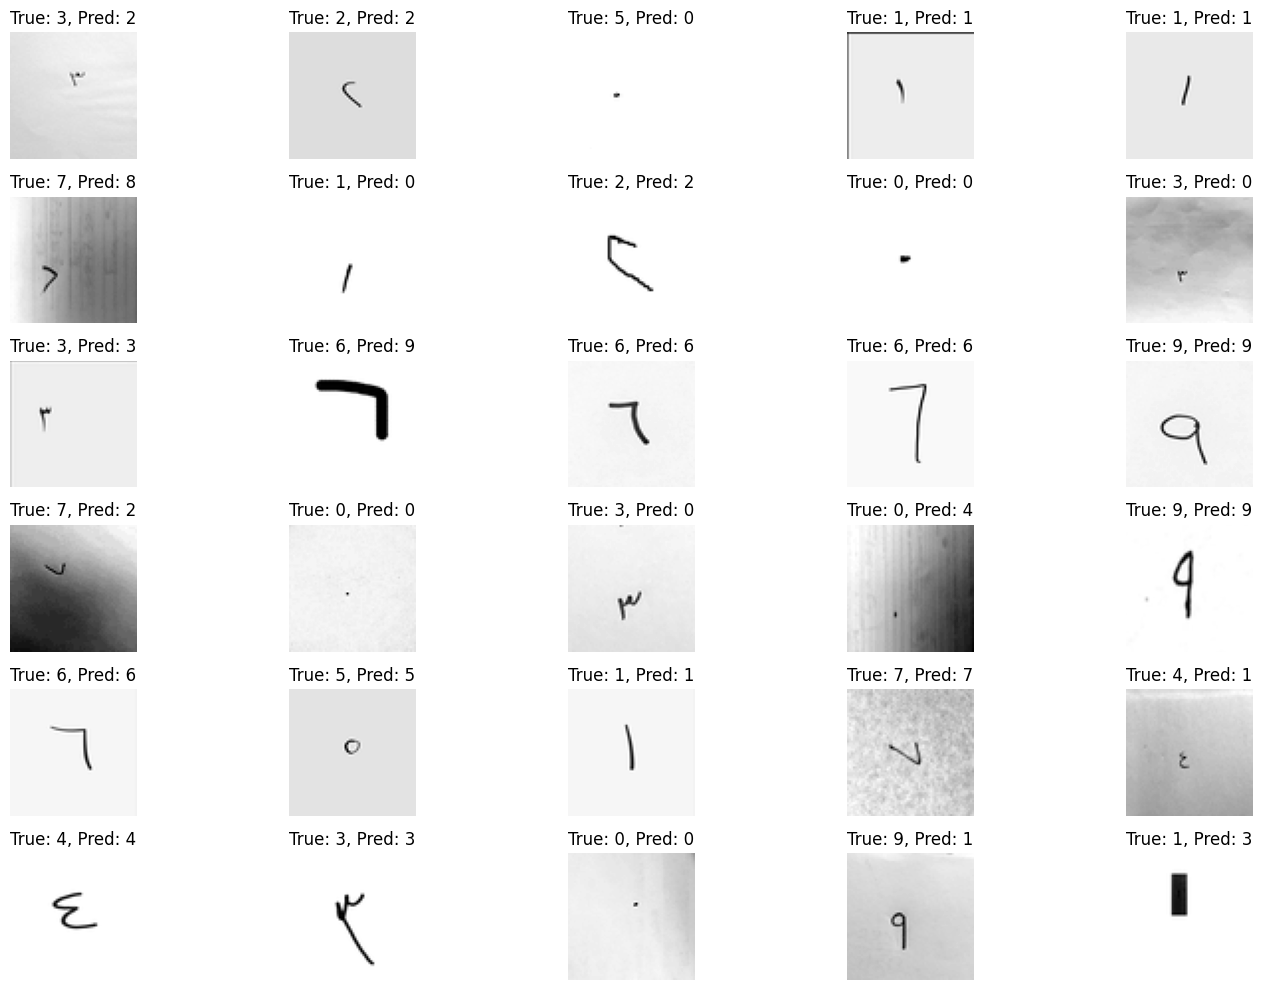

In [62]:
# Making predictions on the test set
predictions = model3.predict(test_images)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Show some of the predictions

def plot_images(images, true_labels, predicted_labels):
    plt.figure(figsize=(15, 10))
    for i in range(30):  # Let's visualize the first 15 images
        plt.subplot(6, 5, i + 1)
        plt.imshow(images[i].reshape(64, 64), cmap='gray')
        plt.title(f"True: {true_labels[i]}, Pred: {predicted_labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function
plot_images(test_images, true_classes, predicted_classes)

In [29]:
from PIL import ImageFilter


In [79]:
# Preprocessing parameters
desired_size = (32, 32)  # Example size, similar to MNIST dataset

# Function to preprocess images: resize and convert to grayscale
def preprocess_image(image):
    image = ImageOps.grayscale(image)  # Convert to grayscale
    image = image.filter(ImageFilter.GaussianBlur(1))  # Apply Gaussian Blur for noise reduction
    image = image.resize(desired_size, Image.Resampling.LANCZOS)  # Resize image using LANCZOS
    return np.array(image)  # Convert to numpy array

# Function to extract the digit label from the zip file name
def extract_digit_from_filename(filename):
    # Assuming the format "Digit-OtherInfo.zip"
    return filename.split('-')[0]

# Function to extract and preprocess images from a zip file
def extract_and_preprocess_images(zip_file_path):
    label = extract_digit_from_filename(os.path.basename(zip_file_path))
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        images_data = {}
        for name in zip_ref.namelist():
            if name.endswith(('.png', '.jpg', '.jpeg')):
                try:
                    # Read image as PIL image
                    image_data = zip_ref.read(name)
                    image = Image.open(io.BytesIO(image_data))
                    # Preprocess image
                    preprocessed_image = preprocess_image(image)
                    # Store image data with label
                    images_data[name] = {'image': preprocessed_image, 'label': label}
                except (OSError, UnidentifiedImageError) as e:
                    print(f"Cannot identify or read image file {name} in {zip_file_path}: {e}")
        return images_data

# First, let's define the directory where the zip files are located
zip_files_dir = r'C:\Users\PC\Downloads\Arabic digits Graduation project\data'
zip_files = [file for file in os.listdir(zip_files_dir) if file.endswith('.zip')]

# Extract, preprocess, and label images from all zip files
all_images_data = []
for zip_file in zip_files:
    print(f"Processing {zip_file}...")
    images_data = extract_and_preprocess_images(os.path.join(zip_files_dir, zip_file))
    all_images_data.extend(list(images_data.values()))
    print(f"Processed {len(images_data)} images from {zip_file}.")

Processing Eight-20240414T070320Z-001.zip...
Processed 251 images from Eight-20240414T070320Z-001.zip.
Processing Five-20240414T070208Z-001.zip...
Processed 256 images from Five-20240414T070208Z-001.zip.
Processing Four-20240414T070029Z-001.zip...
Processed 264 images from Four-20240414T070029Z-001.zip.
Processing Nine-20240413T170740Z-001.zip...
Processed 258 images from Nine-20240413T170740Z-001.zip.
Processing One-20240413T170739Z-001.zip...
Cannot identify or read image file One/Yomna_Yasser_female_21.png in C:\Users\PC\Downloads\Arabic digits Graduation project\data\One-20240413T170739Z-001.zip: cannot identify image file <_io.BytesIO object at 0x0000015905E4AC00>
Processed 260 images from One-20240413T170739Z-001.zip.
Processing Seven-20240413T170601Z-001.zip...
Processed 264 images from Seven-20240413T170601Z-001.zip.
Processing Six-20240413T170559Z-001.zip...
Processed 254 images from Six-20240413T170559Z-001.zip.
Processing Three-20240413T170557Z-001.zip...
Processed 264 image

In [80]:
if all_images_data:
    first_image_data = all_images_data[1500]
    img = Image.fromarray(first_image_data['image'])
    img.show()
    print(f"First image label: {first_image_data['label']}")

First image label: Seven


In [81]:

# Mapping from string labels to integers (you should complete this mapping)
label_mapping = {
    'Zero': 0,
    'One': 1,
    'Two': 2,
    'Three': 3,
    'Four': 4,
    'Five': 5,
    'Six': 6,
    'Seven': 7,
    'Eight': 8,
    'Nine': 9
}

def preprocess_dataset(all_images_data):
    # Separate images and labels
    images = np.array([entry['image'] for entry in all_images_data])
    labels = np.array([label_mapping[entry['label']] for entry in all_images_data])
    
    # Normalize the images
    images = images.astype(np.float32) / 255.0
    
    # Convert labels to one-hot encoding
    labels = to_categorical(labels, num_classes=10)  # Assuming 10 classes for Arabic numerals
    
    # Reshape the images to add the channel dimension (1 channel for grayscale)
    images = images.reshape(-1, 32, 32, 1)
    
    return images, labels


def split_dataset(images, labels, train_frac=0.7, valid_frac=0.15):
    # Calculate sizes for each set
    total_size = len(images)
    train_size = int(train_frac * total_size)
    valid_size = int(valid_frac * total_size)
    test_size = total_size - train_size - valid_size

    # Shuffle the data
    indices = np.arange(total_size)
    np.random.shuffle(indices)
    images, labels = images[indices], labels[indices]

    # Split the data
    train_images, train_labels = images[:train_size], labels[:train_size]
    valid_images, valid_labels = images[train_size:train_size+valid_size], labels[train_size:train_size+valid_size]
    test_images, test_labels = images[train_size+valid_size:], labels[train_size+valid_size:]

    return (train_images, train_labels), (valid_images, valid_labels), (test_images, test_labels)

# Preprocess the entire dataset
images, labels = preprocess_dataset(all_images_data)

# Split the dataset
(train_images, train_labels), (valid_images, valid_labels), (test_images, test_labels) = split_dataset(images, labels)

# Output the sizes of the splits
print(f"Training set size: {len(train_images)}")
print(f"Validation set size: {len(valid_images)}")
print(f"Testing set size: {len(test_images)}")


Training set size: 1815
Validation set size: 388
Testing set size: 390


In [33]:
from keras.regularizers import l2

def build_model():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                     activation='relu', input_shape=(32, 32, 1),
                     kernel_regularizer=l2(0.001)))  # L2 regularization
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                     activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                     activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                     activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax', kernel_regularizer=l2(0.001)))  # Assuming 10 classes for digits 0-9
    return model


# Compile the model
model = build_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,135,082 (4.33 MB)

 Trainable params: 1,134,186 (4.33 MB)

 Non-trainable params: 896 (3.50 KB)

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(
    monitor='val_loss',      # Monitor the validation loss
    patience=10,              # Number of epochs with no improvement after which training will be stopped
    verbose=1,               # To output the progress
    restore_best_weights=True # Restores model weights from the epoch with the best value of the monitored quantity
)


checkpoint_path = "model666_weights_best.weights.h5"  # Changed the extension as per the error message
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',  # or 'val_loss' if you prefer to monitor the loss
    mode='max',  # 'min' if you monitor the loss
    save_best_only=True,
    verbose=1,
)
# Fit the model
history2 = model.fit(
    train_images, train_labels,
    epochs=50,                    # Maximum number of epochs to train for
    batch_size=32,                # The size of the batches to use during training
    validation_data=(valid_images, valid_labels), # Validation data to monitor
    callbacks=[model_checkpoint_callback]      
    )    # Early stopping callback

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1143 - loss: 4.0742
Epoch 1: val_accuracy improved from -inf to 0.10567, saving model to model666_weights_best.weights.h5
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.1147 - loss: 4.0689 - val_accuracy: 0.1057 - val_loss: 3.1513
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1873 - loss: 3.2291
Epoch 2: val_accuracy did not improve from 0.10567
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.1877 - loss: 3.2284 - val_accuracy: 0.1057 - val_loss: 3.2825
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2773 - loss: 2.8946
Epoch 3: val_accuracy did not improve from 0.10567
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.2776 - loss: 2.8933 - val_accuracy: 0.1057 - val_loss: 4.8368
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3931 - loss: 2.5450
Epoch 4: val_accuracy did not improve from 0.10567
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.393

In [36]:
model.load_weights("model666_weights_best.weights.h5")

test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

13/13 - 0s - 8ms/step - accuracy: 0.8205 - loss: 1.2067
Test Loss: 1.2067346572875977
Test Accuracy: 0.8205128312110901


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


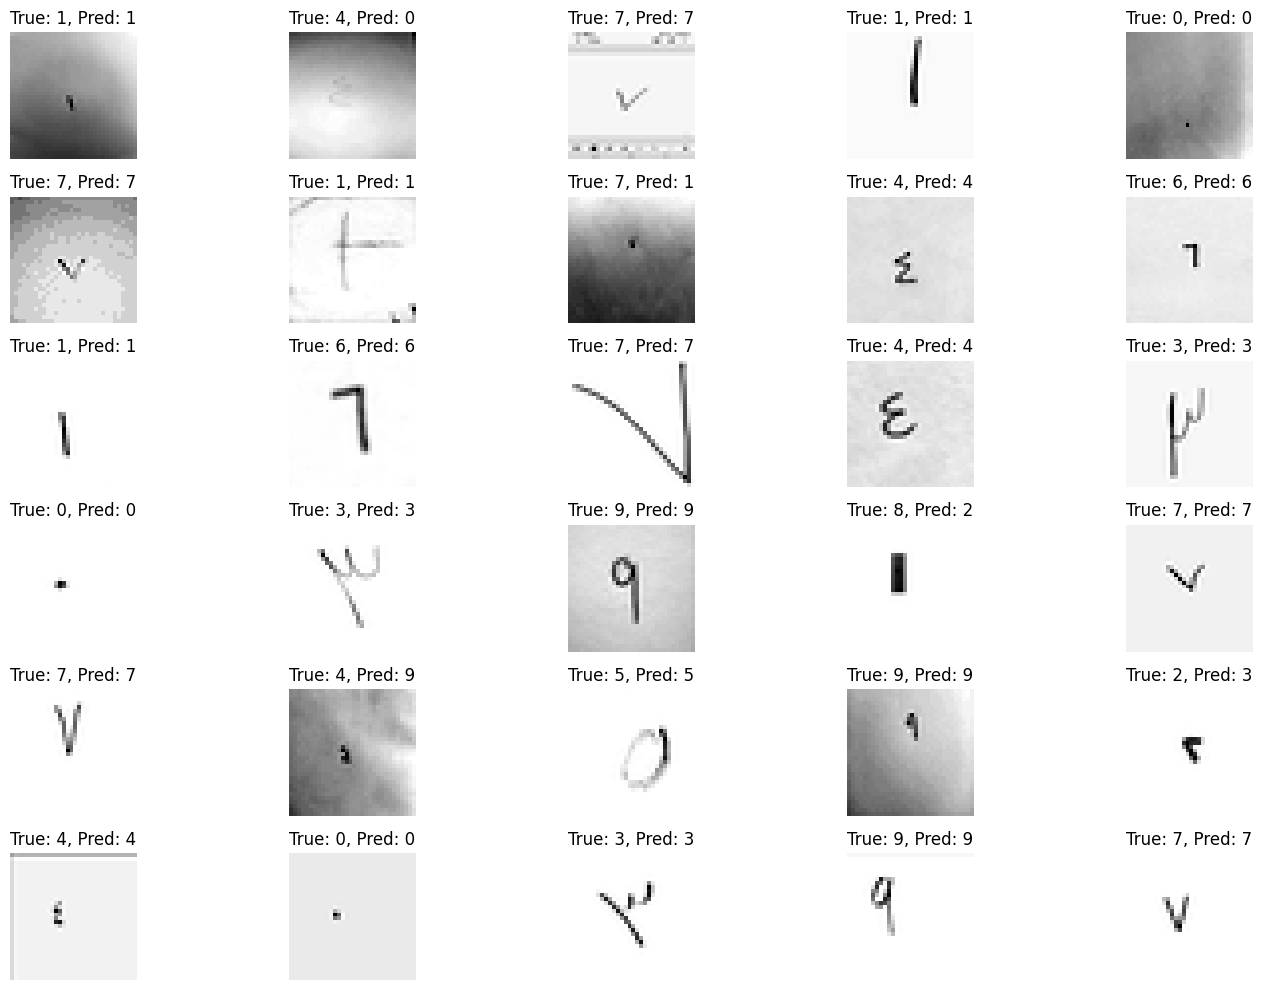

In [37]:
# Making predictions on the test set
predictions = model.predict(test_images)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Show some of the predictions

def plot_images(images, true_labels, predicted_labels):
    plt.figure(figsize=(15, 10))
    for i in range(30):  # Let's visualize the first 15 images
        plt.subplot(6, 5, i + 1)
        plt.imshow(images[i].reshape(32, 32), cmap='gray')
        plt.title(f"True: {true_labels[i]}, Pred: {predicted_labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function
plot_images(test_images, true_classes, predicted_classes)

In [82]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam


In [94]:
from keras.regularizers import l2

def build_model():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                     activation='relu', input_shape=(32, 32, 1),
                     kernel_regularizer=l2(0.001)))  # L2 regularization
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                     activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                     activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                     activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax', kernel_regularizer=l2(0.001)))  # Assuming 10 classes for digits 0-9
    return model


# Compile the model
model2 = build_model()
adam = Adam(learning_rate=0.0001)
model2.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model2.summary()

c:\Users\PC\Downloads\Arabic digits Graduation project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)              │ (None, 32, 32, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 32, 32, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,135,082 (4.33 MB)

 Trainable params: 1,134,186 (4.33 MB)

 Non-trainable params: 896 (3.50 KB)

In [95]:

# Callbacks
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True)

model_checkpoint_callback = ModelCheckpoint(
    filepath="model2_best_weights.weights.h5",  # Adjusted the file extension
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1,
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=5, 
    min_lr=0.001,
    verbose=1)

# Fit the custom model
history_custom_model = model2.fit(
    train_images, train_labels,
    epochs=100, 
    validation_data=(valid_images, valid_labels),
    verbose=1,
    callbacks=[early_stopping_callback, model_checkpoint_callback, reduce_lr])

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0830 - loss: 4.2809
Epoch 1: val_accuracy improved from -inf to 0.08763, saving model to model2_best_weights.weights.h5
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.0832 - loss: 4.2802 - val_accuracy: 0.0876 - val_loss: 3.0118 - learning_rate: 1.0000e-04
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1207 - loss: 3.9267
Epoch 2: val_accuracy did not improve from 0.08763
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.1208 - loss: 3.9268 - val_accuracy: 0.0876 - val_loss: 3.1119 - learning_rate: 1.0000e-04
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1431 - loss: 3.7364
Epoch 3: val_accuracy improved from 0.08763 to 0.10052, saving model to model2_best_weights.weights.h5
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.1430 - loss: 3.7369 - val_accuracy: 0.1005 - val_loss: 3.1184 - learning_rate: 1.0000e-04
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - ac

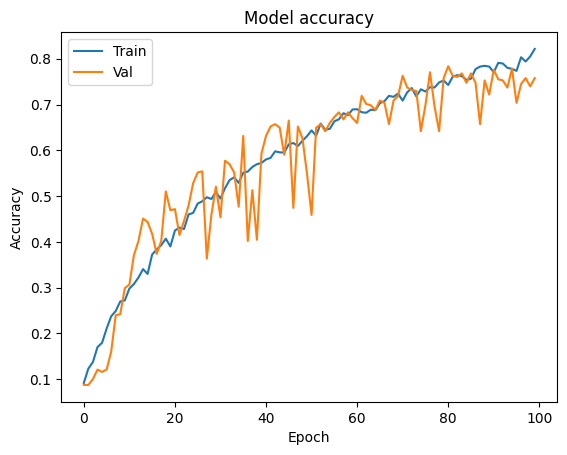

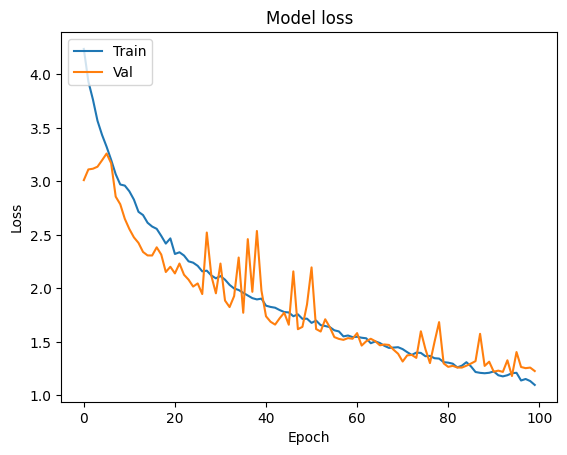

In [96]:
# Plot training & validation accuracy values
plt.plot(history_custom_model.history['accuracy'])
plt.plot(history_custom_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_custom_model.history['loss'])
plt.plot(history_custom_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [97]:
model2.load_weights("model2_best_weights.weights.h5")

test_loss, test_accuracy = model2.evaluate(test_images, test_labels, verbose=2)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

13/13 - 0s - 17ms/step - accuracy: 0.7077 - loss: 1.4519
Test Loss: 1.4519386291503906
Test Accuracy: 0.7076923251152039
